# Variant reclassification based on pathogenicity prediction

# 01 Polyphen2


In [ ]:
#!/usr/bin/env python3
import pandas as pd
import subprocess

# ─── 0. Paths ────────────────────────────────────────────────────────────────
cdkl5_variants    = "/project/ealexov/compbio/shamrat/250519_energy/00_data/" \
                    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
batch_out         = "/project/ealexov/compbio/shamrat/250519_energy/" \
                    "05_pathogenicity/01_polyphen2/cdkl5_mutation_polyphen2.txt"
tsv_in            = "/project/ealexov/compbio/shamrat/250519_energy/" \
                    "05_pathogenicity/01_polyphen2/" \
                    "cdkl5_mutation_polyphen2_results.tsv"
polyphen2_results = "/project/ealexov/compbio/shamrat/250519_energy/" \
                    "05_pathogenicity/01_polyphen2/" \
                    "cdkl5_mutation_polyphen2_results.xlsx"
merged_out        = "/project/ealexov/compbio/shamrat/250519_energy/" \
                    "05_pathogenicity/01_polyphen2/" \
                    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"

uniprot_id = "O76039"


# ─── 1.1 Prepare batch submission for webserver ──────────────────────────────
df = pd.read_excel(cdkl5_variants)
for col in ("wild", "position", "mutant"):
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in {cdkl5_variants}")

lines = []
for _, row in df.iterrows():
    wt, pos, mt = row["wild"], row["position"], row["mutant"]
    if pd.isna(wt) or pd.isna(pos) or pd.isna(mt):
        continue
    lines.append(f"{uniprot_id} {int(pos)} {wt} {mt}")

with open(batch_out, "w") as fo:
    fo.write("\n".join(lines))
print(f"Wrote {len(lines)} variants to {batch_out}")


# ─── 1.2 Preview batch file head ────────────────────────────────────────────
subprocess.run(["head", batch_out])


# ─── 1.3 Convert returned TSV → Excel ────────────────────────────────────────
df_pp2 = pd.read_csv(tsv_in, sep="\t", engine="python")
df_pp2.columns = [c.strip().lstrip("#") for c in df_pp2.columns]
df_pp2.to_excel(polyphen2_results, index=False)
print(f"Wrote {len(df_pp2)} rows to {polyphen2_results}")


# ─── 1.4 Preview the new Excel & original columns ───────────────────────────
df_check = pd.read_excel(polyphen2_results)
print("PolyPhen-2 results head:\n", df_check.head().to_string(), "\n")
df_orig = pd.read_excel(cdkl5_variants)
print("cdkl5_variants columns:", df_orig.columns.tolist())


# ─── 1.5 Merge PolyPhen-2 into  variants (1:1 mapping) ───────────────────
variants_df = pd.read_excel(cdkl5_variants)
pp2_df       = pd.read_excel(polyphen2_results)

# Normalize key columns
variants_df['position'] = variants_df['position'].astype(int)
pp2_df['pos']          = pp2_df['pos'].astype(int)

# Select + rename
cols_to_pull = ['pos', 'prediction', 'pph2_prob', 'pph2_FPR', 'pph2_TPR']
pp2_small    = pp2_df[cols_to_pull].rename(columns={'pos': 'position'})

# Drop any duplicate positions (keep the first)
pp2_unique = pp2_small.drop_duplicates(subset='position', keep='first')

# Map back onto the original DataFrame
lookup = pp2_unique.set_index('position')
for col in ['prediction', 'pph2_prob', 'pph2_FPR', 'pph2_TPR']:
    variants_df[col] = variants_df['position'].map(lookup[col])

# Optional diagnostics
missing = variants_df['prediction'].isna().sum()
print(f"{missing} out of {len(variants_df)} variants had NO PolyPhen-2 result.")
extra_pp2 = set(pp2_unique['position']) - set(variants_df['position'])
print(f"{len(extra_pp2)} PolyPhen-2 positions didn’t match any original variants.")

# Write merged file
variants_df.to_excel(merged_out, index=False)
print(f"Wrote {len(variants_df)} rows (1:1 mapping) to {merged_out}")


Wrote 156 variants to /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/cdkl5_mutation_polyphen2.txt
O76039 3 I F
O76039 5 N D
O76039 13 F S
O76039 20 G R
O76039 20 G V
O76039 20 G D
O76039 21 E G
O76039 22 G V
O76039 22 G E
O76039 24 Y C
Wrote 156 rows to /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/cdkl5_mutation_polyphen2_results.xlsx
PolyPhen-2 results head:
                   o_acc  o_pos  o_aa1  o_aa2        rsid         acc  pos  aa1  aa2          prediction  pph2_prob  pph2_FPR  pph2_TPR
0  O76039                    3      I      F           ?  O76039        3    I    F   probably damaging      0.999   0.00574   0.13600
1  O76039                    5      N      D           ?  O76039        5    N    D              benign      0.114   0.14200   0.92700
2  O76039                   13      F      S           ?  O76039       13    F    S   probably damaging      1.000   0.00026   0.00018
3  O76039                   20     

In [8]:
import pandas as pd
from IPython.display import display

file_path = '/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx'

# Read Excel
df = pd.read_excel(file_path)

# Display the first few rows (nicely in Jupyter/IPython)
display(df.head())

# Print column names as a list
def print_column_names(dataframe):
    print("🧩 Column names:")
    for col in dataframe.columns:
        print(f"- {col}")

print_column_names(df)


,Name,Gene(s),Protein change,mutation,wild,position,mutant,Allele Frequency,Condition(s),Accession,...,Variant type,Molecular consequence,Germline classification,Source,Germline date last evaluated,Germline review status,prediction,pph2_prob,pph2_FPR,pph2_TPR
0,ENSP00000369325.3:p.Ile3Phe,CDKL5,I3F,I3F,I,3,F,0.000009,Healthy,NaN,...,single nucleotide variant,missense_variant,Benign,1000genome,NaN,NaN,probably damaging,0.999,0.00574,0.13600
1,ENSP00000369325.3:p.Asn5Asp,CDKL5,N5D,N5D,N,5,D,0.000003,Healthy,NaN,...,single nucleotide variant,missense_variant,Benign,1000genome,NaN,NaN,benign,0.114,0.14200,0.92700
2,NM_001323289.2(CDKL5):c.38T>C (p.Phe13Ser),CDKL5,F13S,F13S,F,13,S,NaN,CDKL5 disorder,VCV000929426,...,single nucleotide variant,missense variant,Likely pathogenic,Clinvar,"Sep 1, 2022",reviewed by expert panel,probably damaging,1.000,0.00026,0.00018
3,NM_001323289.2(CDKL5):c.58G>C (p.Gly20Arg),CDKL5,G20R,G20R,G,20,R,NaN,"Developmental and epileptic encephalopathy, 2|...",VCV000143828,...,single nucleotide variant,missense variant,Pathogenic,Clinvar,"Nov 11, 2024","criteria provided, multiple submitters, no con...",probably damaging,1.000,0.00026,0.00018
4,NM_001323289.2(CDKL5):c.59G>T (p.Gly20Val),CDKL5,G20V,G20V,G,20,V,NaN,CDKL5 disorder,VCV000918032,...,single nucleotide variant,missense variant,Pathogenic,Clinvar,"Mar 26, 2021",reviewed by expert panel,probably damaging,1.000,0.00026,0.00018


🧩 Column names:
- Name
- Gene(s)
- Protein change
- mutation
- wild
- position
- mutant
- Allele Frequency
- Condition(s)
- Accession
- GRCh37Chromosome
- GRCh37Location
- GRCh38Chromosome
- GRCh38Location
- VariationID
- AlleleID(s)
- dbSNP ID
- Canonical SPDI
- Variant type
- Molecular consequence
- Germline classification
- Source
- Germline date last evaluated
- Germline review status
- prediction
- pph2_prob
- pph2_FPR
- pph2_TPR


## 1.1 Class count of 'Germline classification' and 'Prediction' column

In [14]:
import pandas as pd

# Load the merged table
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"
)
df = pd.read_excel(file_path)

# 1) Ensure 'position' is numeric, then filter to 1–302
df['position'] = pd.to_numeric(df['position'], errors='coerce')
df = df[df['position'].between(1, 302)]

# 2) Germline classification counts
germ_counts = df['Germline classification'] \
    .value_counts(dropna=False) \
    .rename_axis('Germline classification') \
    .reset_index(name='Count')
print("Germline classification (positions 1–302):")
print(germ_counts.to_string(index=False))

# 3) Raw PolyPhen-2 prediction counts (all three classes)
df['prediction_clean'] = df['prediction'].str.lower().str.strip()
raw_pred_counts = df['prediction_clean'] \
    .value_counts(dropna=False) \
    .rename_axis('PolyPhen-2 prediction') \
    .reset_index(name='Count')
print("\nPolyPhen-2 predictions (positions 1–302):")
print(raw_pred_counts.to_string(index=False))


Germline classification (positions 1–302):
                     Germline classification  Count
                      Uncertain significance     30
                Pathogenic/Likely pathogenic     24
                           Likely pathogenic     22
                        Benign/Likely benign     12
Conflicting classifications of pathogenicity     10
                                  Pathogenic      9
                                      Benign      4
                               Likely benign      1

PolyPhen-2 predictions (positions 1–302):
PolyPhen-2 prediction  Count
    probably damaging     98
               benign      7
    possibly damaging      7


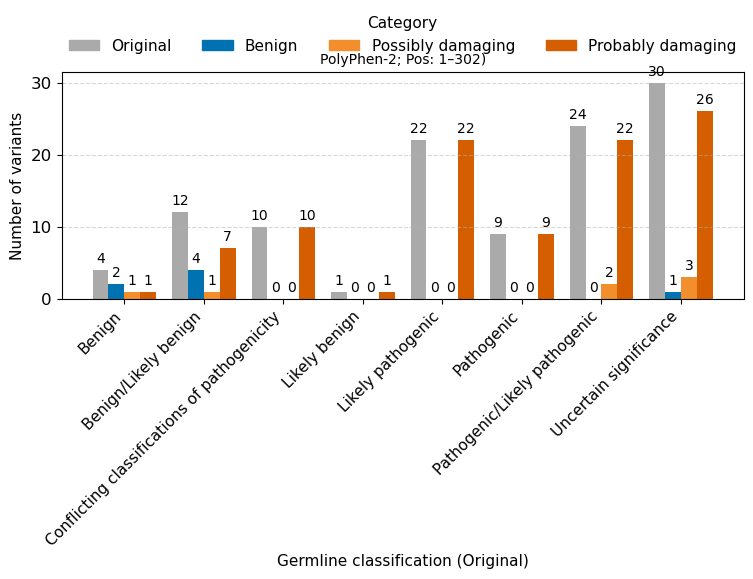

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_reclassification(
    df: pd.DataFrame,
    position_range=(1, 302),
    figsize=(10, 6),
    title_fontsize=16,
    label_fontsize=14,
    tick_fontsize=12,
    annotation_fontsize=10,
    bar_width_ratio=0.8,
    colors=None,
    title=None
):
    """
    Plot original Germline classification counts alongside PolyPhen-2 prediction breakdown.
    Allows separate control of title, label, tick, and annotation font sizes.

    Parameters:
    - df: DataFrame with columns 'position', 'Germline classification', 'prediction'
    - position_range: tuple(min, max) to filter 'position'
    - figsize: tuple(width, height)
    - title_fontsize: font size for the title
    - label_fontsize: font size for axis labels
    - tick_fontsize: font size for tick labels
    - annotation_fontsize: font size for the bar count annotations
    - bar_width_ratio: total width occupied by all bars per group (fraction of 1)
    - colors: dict mapping 'original' and prediction labels to colors
    - title: optional plot title
    """
    # Filter & clean
    df = df[df['position'].between(*position_range)].copy()
    df['prediction_clean'] = df['prediction'].str.lower().str.strip()

    # Prepare data
    preds = ['benign', 'possibly damaging', 'probably damaging']
    cross = pd.crosstab(df['Germline classification'], df['prediction_clean'])[preds]
    original = df['Germline classification'].value_counts().reindex(cross.index)

    # Default colors
    if colors is None:
        colors = {
            'original': '#AAAAAA',
            'benign': '#0072B2',
            'possibly damaging': '#F28E2B',
            'probably damaging': '#D55E00'
        }

    fig, ax = plt.subplots(figsize=figsize)

    n_groups = len(cross)
    n_bars = 1 + len(preds)
    total_width = bar_width_ratio
    bar_width = total_width / n_bars
    x = np.arange(n_groups)

    # Plot
    for i, key in enumerate(['original'] + preds):
        counts = original.values if key == 'original' else cross[key].values
        offset = -total_width/2 + i * bar_width + bar_width/2
        positions = x + offset
        ax.bar(positions, counts, bar_width, color=colors[key],
               label='Original' if key=='original' else key.capitalize())
        # Annotate
        for pos, cnt in zip(positions, counts):
            ax.text(pos, cnt + max(original.max(), cross.values.max())*0.02,
                    str(int(cnt)), ha='center', va='bottom',
                    fontsize=annotation_fontsize)

    # Axes & Title
    ax.set_xticks(x)
    ax.set_xticklabels(cross.index, rotation=45, ha='right', fontsize=tick_fontsize)
    ax.set_xlabel('Germline classification (Original)', fontsize=label_fontsize)
    ax.set_ylabel('Number of variants', fontsize=label_fontsize)
    ax.set_title(title or f'Reclassification vs. Original Counts\n(Positions {position_range[0]}–{position_range[1]})',
                 fontsize=title_fontsize)

    # Legend above
    handles = [Patch(color=colors['original'], label='Original')] + \
              [Patch(color=colors[p], label=p.capitalize()) for p in preds]
    ax.legend(handles=handles, title='Category',
              loc='lower center', bbox_to_anchor=(0.5, 1.02),
              ncol=len(handles), frameon=False, fontsize=tick_fontsize, title_fontsize=label_fontsize)

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# -----------------------
# Example usage:
# -----------------------
if __name__ == "__main__":
    # Load merged table
    file_path = (
        "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/"
        "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"
    )
    df_merged = pd.read_excel(file_path)

    # Plot with custom font sizes
    plot_reclassification(
        df_merged,
        position_range=(1, 302),
        figsize=(8, 6),
        title_fontsize=10,
        label_fontsize=11,
        tick_fontsize=11,
        annotation_fontsize=10,
        bar_width_ratio=0.8,
        title="PolyPhen-2; Pos: 1–302)"
    )


In [ ]:
import pandas as pd
from IPython.display import display

# 1) Load merged PolyPhen-2 results table
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"
)
df = pd.read_excel(file_path)

# 2) Select the columns you asked for
cols = [
    'mutation',
    'position',
    'Germline classification',
    'prediction',
    'pph2_prob',
    'pph2_FPR',
    'pph2_TPR'
]

# 3) Display the first five rows in IPython
display(df[cols].head())


,mutation,position,Germline classification,prediction,pph2_prob,pph2_FPR,pph2_TPR
0,I3F,3,Benign,probably damaging,0.999,0.00574,0.13600
1,N5D,5,Benign,benign,0.114,0.14200,0.92700
2,F13S,13,Likely pathogenic,probably damaging,1.000,0.00026,0.00018
3,G20R,20,Pathogenic,probably damaging,1.000,0.00026,0.00018
4,G20V,20,Pathogenic,probably damaging,1.000,0.00026,0.00018


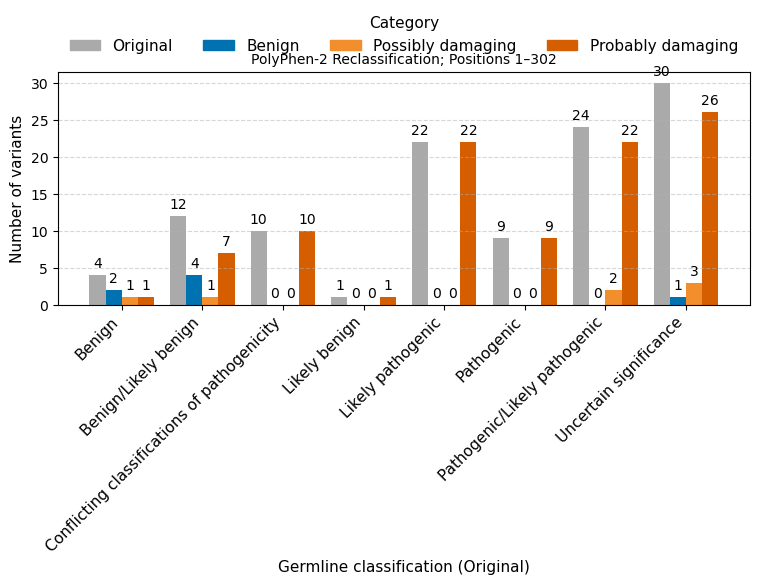


PolyPhen-2 class counts:
prediction_clean
Benign                7
Possibly damaging     7
Probably damaging    98
Name: count, dtype: int64


In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_reclassification(
    df: pd.DataFrame,
    position_range=(1, 302),
    figsize=(10, 6),
    title_fontsize=16,
    label_fontsize=14,
    tick_fontsize=12,
    annotation_fontsize=10,
    bar_width_ratio=0.8,
    colors=None,
    title=None
) -> pd.Series:
    """
    Plot original Germline classification counts alongside PolyPhen-2 prediction breakdown,
    and return the PolyPhen-2 class counts.

    Returns:
    - A pandas Series indexed by ['benign','possibly damaging','probably damaging']
      with the counts of each PolyPhen-2 class.
    """
    # Filter & clean
    df = df[df['position'].between(*position_range)].copy()
    df['prediction_clean'] = df['prediction'].str.lower().str.strip()

    # Prepare data for plotting
    preds = ['benign', 'possibly damaging', 'probably damaging']
    cross = pd.crosstab(df['Germline classification'], df['prediction_clean'])[preds]
    original = df['Germline classification'].value_counts().reindex(cross.index)

    # Compute PolyPhen-2 counts
    polyphen_counts = df['prediction_clean'].value_counts().reindex(preds, fill_value=0)

    # Default colors
    if colors is None:
        colors = {
            'original': '#AAAAAA',
            'benign': '#0072B2',
            'possibly damaging': '#F28E2B',
            'probably damaging': '#D55E00'
        }

    fig, ax = plt.subplots(figsize=figsize)

    n_groups = len(cross)
    n_bars = 1 + len(preds)
    total_width = bar_width_ratio
    bar_width = total_width / n_bars
    x = np.arange(n_groups)

    # Plot bars + annotations
    for i, key in enumerate(['original'] + preds):
        counts = original.values if key == 'original' else cross[key].values
        offset = -total_width/2 + i * bar_width + bar_width/2
        positions = x + offset
        ax.bar(positions, counts, bar_width, color=colors[key],
               label='Original' if key == 'original' else key.capitalize())
        for pos, cnt in zip(positions, counts):
            ax.text(pos, cnt + max(original.max(), cross.values.max())*0.02,
                    str(int(cnt)), ha='center', va='bottom',
                    fontsize=annotation_fontsize)

    # Axes & Title
    ax.set_xticks(x)
    ax.set_xticklabels(cross.index, rotation=45, ha='right', fontsize=tick_fontsize)
    ax.set_xlabel('Germline classification (Original)', fontsize=label_fontsize)
    ax.set_ylabel('Number of variants', fontsize=label_fontsize)
    ax.set_title(title or f'Reclassification vs. Original Counts\n'
                         f'(Positions {position_range[0]}–{position_range[1]})',
                 fontsize=title_fontsize)

    # Legend above
    handles = [Patch(color=colors['original'], label='Original')] + \
              [Patch(color=colors[p], label=p.capitalize()) for p in preds]
    ax.legend(handles=handles, title='Category',
              loc='lower center', bbox_to_anchor=(0.5, 1.02),
              ncol=len(handles), frameon=False,
              fontsize=tick_fontsize, title_fontsize=label_fontsize)

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return polyphen_counts


if __name__ == "__main__":
    # Path to merged table
    file_path = (
        "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/"
        "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"
    )
    df_merged = pd.read_excel(file_path)

    # Plot and retrieve PolyPhen-2 class counts
    counts = plot_reclassification(
        df_merged,
        position_range=(1, 302),
        figsize=(8, 6),
        title_fontsize=10,
        label_fontsize=11,
        tick_fontsize=11,
        annotation_fontsize=10,
        bar_width_ratio=0.8,
        title="PolyPhen-2 Reclassification; Positions 1–302"
    )

    # Print the PolyPhen-2 counts
    print("\nPolyPhen-2 class counts:")
    print(counts.rename(index={
        'benign': 'Benign',
        'possibly damaging': 'Possibly damaging',
        'probably damaging': 'Probably damaging'
    }))


# 02 MutPred2

## 2.1 Prepare fasta file with mutation for Mutpred2

In [ ]:
## MutPred2
## 2.1 Prepare fasta file with mutation for Mutpred2
#!/usr/bin/env python3
import os
import requests
import pandas as pd
from textwrap import wrap

# ─────── CONFIG ───────
UNIPROT_ID = "O76039"
OUT_DIR    = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2"
BASENAME   = "cdkl5_mutation_mutpred2"
XLSX_PATH  = "/project/ealexov/compbio/shamrat/250519_energy/00_data/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"
WILD_COL   = "wild"
POS_COL    = "position"
MUT_COL    = "mutant"
SPECIES_TAG= "CDKL5_HUMAN"
MAX_PER    = 100
# ──────────────────────

# 1) fetch WT sequence from UniProt
url   = f"https://rest.uniprot.org/uniprotkb/{UNIPROT_ID}.fasta"
resp  = requests.get(url)
resp.raise_for_status()
lines = resp.text.strip().splitlines()
seq   = "".join(lines[1:])

# 2) read      spreadsheet & build mutation tags
df   = pd.read_excel(XLSX_PATH, usecols=[WILD_COL,POS_COL,MUT_COL])
tags = [f"{wt}{int(pos)}{mt}" for wt,pos,mt in df.itertuples(index=False)]

# 3) chunk into ≤MAX_PER and write one FASTA per chunk
os.makedirs(OUT_DIR, exist_ok=True)
for i in range(0, len(tags), MAX_PER):
    chunk = tags[i : i+MAX_PER]
    idx   = i//MAX_PER + 1
    out_f = os.path.join(OUT_DIR, f"{BASENAME}_part{idx}.fasta")
    with open(out_f, "w") as fh:
        header = f">{SPECIES_TAG}_part{idx} " + " ".join(chunk)
        fh.write(header + "\n")
        for line in wrap(seq, 60):
            fh.write(line + "\n")
    print(f"→ wrote {out_f}")


→ wrote /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/cdkl5_mutation_mutpred2_part1.fasta
→ wrote /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/cdkl5_mutation_mutpred2_part2.fasta


## 2.2 Submit the fasta files and retrived the result

In [ ]:
submit it on server

## 2.3 Process Mutpred2 results

In [ ]:
## 2.3 Read Mutpred2 part1 and part2 csv

# === 2.3a View the first few lines of  MutPred2 result CSVs ===S
print('=== 2.3a View the first few lines of  MutPred2 result CSVs ===')

import pandas as pd

# Updated paths with  new filenames
part1_csv = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/" \
            "cdkl5_mutation_mutpred2_part1_result.csv"
part2_csv = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/" \
            "cdkl5_mutation_mutpred2_part2_result.csv"

# Load and display the first 5 rows of part 1
df1 = pd.read_csv(part1_csv)
print(f"Head of {part1_csv}:")
print(df1.head().to_string(), "\n")

# Load and display the first 5 rows of part 2
df2 = pd.read_csv(part2_csv)
print(f"Head of {part2_csv}:")
print(df2.head().to_string())








# === 2.3b Combine      two MutPred2 CSVs into one table with proper headers ===

import pandas as pd
import os

# paths to  part-1 and part-2 result CSVs
dir02 = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2"
part1_csv = os.path.join(dir02, "cdkl5_mutation_mutpred2_part1_result.csv")
part2_csv = os.path.join(dir02, "cdkl5_mutation_mutpred2_part2_result.csv")

# 1) Define the column names in the correct order
column_names = [
    "ID",
    "Substitution",
    "MutPred2_score",
    "Molecular_mechanisms",
    "Affected_PROSITE_and_ELM_Motifs",
    "Remarks"
]

# 2) Read each CSV without a header row, assigning  names
df1 = pd.read_csv(part1_csv, header=None, names=column_names)
df2 = pd.read_csv(part2_csv, header=None, names=column_names)

# 3) Concatenate into a single DataFrame
combined = pd.concat([df1, df2], ignore_index=True)

# 4) (Optional) inspect the first few rows
print(combined.head().to_string())

# 5) Write out to a new Excel file, matching  filename style
out_xlsx = os.path.join(
    dir02,
    "cdkl5_mutation_mutpred2_results_combined.xlsx"
)
combined.to_excel(out_xlsx, index=False)
print(f"Wrote combined MutPred2 results to {out_xlsx}")




# === 2.3c Merge MutPred2 into  CDKL5 variants and save ===

import pandas as pd
import os

# paths
variants_xlsx = "/project/ealexov/compbio/shamrat/250519_energy/00_data/" \
                "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
mutpred2_dir  = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2"

# use the exact combined filename you generated
combined_xlsx = os.path.join(
    mutpred2_dir,
    "cdkl5_mutation_mutpred2_results_combined.xlsx"
)

# 1) Read      original variants and the combined MutPred2 results
variants_df = pd.read_excel(variants_xlsx, engine="openpyxl")
mutpred_df  = pd.read_excel(combined_xlsx, engine="openpyxl")

# 2) Merge on the variant string: 'mutation' in variants matches 'Substitution' in MutPred2
merged = variants_df.merge(
    mutpred_df,
    left_on="mutation",
    right_on="Substitution",
    how="left"
)

# 3) Write out to Excel, appending '_mutpred2' to the original base name
base = os.path.splitext(os.path.basename(variants_xlsx))[0]
out_path = os.path.join(
    mutpred2_dir,
    f"{base}_mutpred2.xlsx"
)
merged.to_excel(out_path, index=False)
print(f"Wrote merged MutPred2 annotations to {out_path}")


=== 2.3a View the first few lines of your MutPred2 result CSVs ===
Head of /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/cdkl5_mutation_mutpred2_part1_result.csv:
   CDKL5_HUMAN_part1   I3F  0.286                                                                                                                                                                                                                                                                                                                                   -                             -.1  Predicted conservation scores
0  CDKL5_HUMAN_part1   N5D  0.135                                                                                                                                                                                                                                                                                                                                   -                             

In [ ]:
## display mutpred2

In [ ]:
import pandas as pd
from IPython.display import display

# 1) Load  merged MutPred2 results
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_mutpred2.xlsx"
)
df = pd.read_excel(file_path, engine="openpyxl")

# 2) Print all column names
print("Columns in the DataFrame:")
print(df.columns.tolist(), "\n")

# 3) Display the first five rows of key columns
cols = [
    "mutation",
    "position",
    "Germline classification",
    "Substitution",
    "MutPred2_score",
    "Molecular_mechanisms",
    "Affected_PROSITE_and_ELM_Motifs",
    "Remarks"
]
display(df[cols].head())


Columns in the DataFrame:
['Name', 'Gene(s)', 'Protein change', 'mutation', 'wild', 'position', 'mutant', 'Allele Frequency', 'Condition(s)', 'Accession', 'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome', 'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence', 'Germline classification', 'Source', 'Germline date last evaluated', 'Germline review status', 'ID', 'Substitution', 'MutPred2_score', 'Molecular_mechanisms', 'Affected_PROSITE_and_ELM_Motifs', 'Remarks'] 



,mutation,position,Germline classification,Substitution,MutPred2_score,Molecular_mechanisms,Affected_PROSITE_and_ELM_Motifs,Remarks
0,I3F,3,Benign,I3F,0.286,-,-,Predicted conservation scores
1,N5D,5,Benign,N5D,0.135,-,-,Predicted conservation scores
2,F13S,13,Likely pathogenic,F13S,0.895,Altered Ordered interface (Pr = 0.32 | P = 0.0...,ELME000070|ELME000335|PS00001,Predicted conservation scores
3,G20R,20,Pathogenic,G20R,0.912,Gain of Allosteric site at Y24 (Pr = 0.33 | P ...,PS00107,Predicted conservation scores
4,G20V,20,Pathogenic,G20V,0.928,Altered Metal binding (Pr = 0.32 | P = 0.01); ...,ELME000333|PS00107,Predicted conservation scores


## 2.4 assign mutpred2 threshold

In [ ]:
import pandas as pd
import os

# Directory containing  _ MutPred2 Excel
mutpred2_dir = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2"

# Input and output filenames
infile  = "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_mutpred2.xlsx"
# Keep 'mutpred2' at the end of the filename
outfile = "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"

# Paths
in_path  = os.path.join(mutpred2_dir, infile)
out_path = os.path.join(mutpred2_dir, outfile)

# 1) Load the merged MutPred2 results
df = pd.read_excel(in_path, engine="openpyxl")

# 2) Add classification column at 0.67 threshold
df['MutPred2_classification'] = df['MutPred2_score'].apply(
    lambda x: 'Pathogenic' if x >= 0.67 else 'Benign'
)

# 3) Save the new file
df.to_excel(out_path, index=False)
print(f"Wrote results with MutPred2 classification to:\n  {out_path}")


Wrote results with MutPred2 classification to:
  /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx


In [ ]:
## important columns

In [ ]:
import pandas as pd
from IPython.display import display

# 1) Path to classified MutPred2 results file
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"
)

# 2) Read the Excel into a DataFrame
df = pd.read_excel(file_path, engine="openpyxl")

# 3) Define columns to display
cols = [
    "mutation",
    "position",
    "Germline classification",
    "MutPred2_score",
    "MutPred2_classification",
    "Molecular_mechanisms",
    "Affected_PROSITE_and_ELM_Motifs",
    "Remarks"
]

# 4) Print the column names
print("Displayed columns:")
print(cols, "\n")

# 5) Display the first five rows
display(df[cols].head())


Displayed columns:
['mutation', 'position', 'Germline classification', 'MutPred2_score', 'MutPred2_classification', 'Molecular_mechanisms', 'Affected_PROSITE_and_ELM_Motifs', 'Remarks'] 



,mutation,position,Germline classification,MutPred2_score,MutPred2_classification,Molecular_mechanisms,Affected_PROSITE_and_ELM_Motifs,Remarks
0,I3F,3,Benign,0.286,Benign,-,-,Predicted conservation scores
1,N5D,5,Benign,0.135,Benign,-,-,Predicted conservation scores
2,F13S,13,Likely pathogenic,0.895,Pathogenic,Altered Ordered interface (Pr = 0.32 | P = 0.0...,ELME000070|ELME000335|PS00001,Predicted conservation scores
3,G20R,20,Pathogenic,0.912,Pathogenic,Gain of Allosteric site at Y24 (Pr = 0.33 | P ...,PS00107,Predicted conservation scores
4,G20V,20,Pathogenic,0.928,Pathogenic,Altered Metal binding (Pr = 0.32 | P = 0.01); ...,ELME000333|PS00107,Predicted conservation scores


In [ ]:
## Reclassification plot for MutPred2

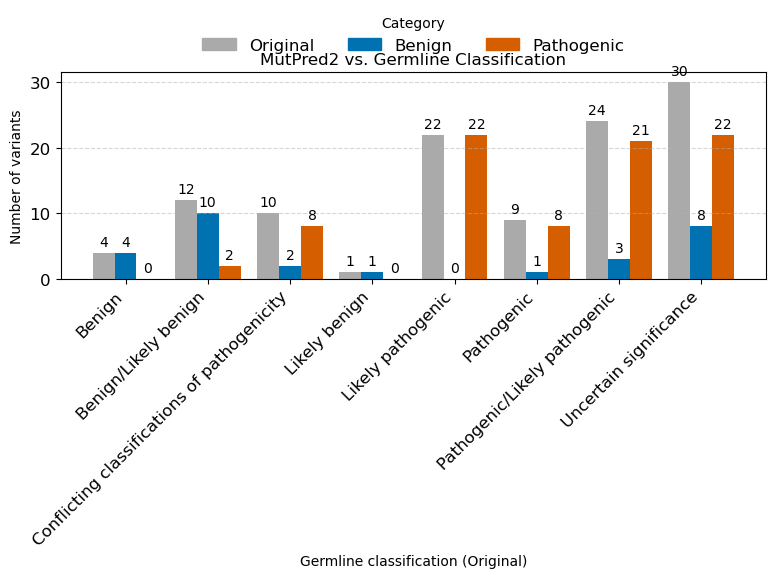

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_mutpred2_reclassification(
    df: pd.DataFrame,
    position_range=(1, 302),
    figsize=(10, 6),
    title_fontsize=16,
    label_fontsize=14,
    tick_fontsize=12,
    annotation_fontsize=10,
    bar_width_ratio=0.8,
    colors=None,
    title=None
):
    """
    Plot original Germline classification counts alongside MutPred2 reclassification.

    Parameters:
    - df: DataFrame with 'position', 'Germline classification', 'MutPred2_classification'
    - position_range: tuple(min, max) to filter 'position'
    - figsize: tuple(width, height) for figure
    - title_fontsize: fontsize for title
    - label_fontsize: fontsize for axis labels
    - tick_fontsize: fontsize for tick labels
    - annotation_fontsize: fontsize for bar annotations
    - bar_width_ratio: total group width fraction
    - colors: dict mapping 'Original', 'Benign', 'Pathogenic' to colors
    - title: optional plot title
    """
    # Filter and subset
    df = df[df['position'].between(*position_range)].copy()
    # Cross-tabulate
    cross = pd.crosstab(df['Germline classification'], df['MutPred2_classification'])
    original = df['Germline classification'].value_counts().reindex(cross.index)

    # Default colors
    if colors is None:
        colors = {
            'Original':   '#AAAAAA',
            'Benign':     '#0072B2',
            'Pathogenic': '#D55E00'
        }

    # Plot setup
    fig, ax = plt.subplots(figsize=figsize)
    plt.rcParams.update({'font.size': tick_fontsize})

    categories = ['Original', 'Benign', 'Pathogenic']
    n_groups = len(cross)
    n_bars = len(categories)
    total_width = bar_width_ratio
    bar_width = total_width / n_bars
    x = np.arange(n_groups)

    # Plot bars
    for i, cat in enumerate(categories):
        counts = original.values if cat == 'Original' else cross.get(cat, pd.Series(0, index=cross.index)).values
        offset = -total_width/2 + i * bar_width + bar_width/2
        positions = x + offset
        ax.bar(positions, counts, bar_width, color=colors[cat], label=cat)
        # Annotations
        for pos, cnt in zip(positions, counts):
            ax.text(pos, cnt + max(original.max(), cross.values.max())*0.02,
                    str(int(cnt)), ha='center', va='bottom', fontsize=annotation_fontsize)

    # Labels and title
    ax.set_xticks(x)
    ax.set_xticklabels(cross.index, rotation=45, ha='right', fontsize=tick_fontsize)
    ax.set_xlabel('Germline classification (Original)', fontsize=label_fontsize)
    ax.set_ylabel('Number of variants', fontsize=label_fontsize)
    ax.set_title(title or f'MutPred2 Reclassification vs. Original\n(Positions {position_range[0]}–{position_range[1]})',
                 fontsize=title_fontsize)

    # Legend above
    handles = [Patch(color=colors[c], label=c) for c in categories]
    ax.legend(handles=handles, title='Category',
              loc='lower center', bbox_to_anchor=(0.5, 1.02),
              ncol=len(handles), frameon=False, fontsize=tick_fontsize, title_fontsize=label_fontsize)

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Load classified MutPred2 results
    path = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/" \
           "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"
    df = pd.read_excel(path, engine="openpyxl")
    # Plot with custom styling
    plot_mutpred2_reclassification(
        df,
        position_range=(1, 302),
        figsize=(8, 6),
        title_fontsize=12,
        label_fontsize=10,
        tick_fontsize=12,
        annotation_fontsize=10,
        bar_width_ratio=0.8,
        title="MutPred2 vs. Germline Classification"
    )


In [ ]:
import pandas as pd

def load_and_reclassify_polyphen(
    file_path: str,
    position_range: tuple[int, int] = (1, 302)
) -> pd.Series:
    """
    Load a PolyPhen-2 results table, restrict to a given position range,
    clean the predictions, and reclassify into two bins: Benign vs. Pathogenic.

    Parameters:
        file_path (str): Path to the Excel file with columns 'position' and 'prediction'.
        position_range (tuple[int, int]): (start, end) positions inclusive.

    Returns:
        pd.Series: Counts for each of the two new classes ('Benign', 'Pathogenic').
    """
    # 1) Load the Excel file into a DataFrame
    df = pd.read_excel(file_path)

    # 2) Restrict to the specified position range
    start, end = position_range
    df = df[df['position'].between(start, end)].copy()

    # 3) Normalize the original prediction strings
    df['prediction_clean'] = (
        df['prediction']
        .str.lower()
        .str.strip()
    )

    # 4) Map to two classes: Benign stays Benign, all others → Pathogenic
    df['pp2_binary'] = df['prediction_clean'].apply(
        lambda x: 'Benign' if x == 'benign' else 'Pathogenic'
    )

    # 5) Count the occurrences of each class
    counts = df['pp2_binary'].value_counts().reindex(
        ['Benign', 'Pathogenic'],
        fill_value=0
    )
    return counts

if __name__ == "__main__":
    # Path to  _ merged PolyPhen-2 output
    file_path = (
        "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/01_polyphen2/"
        "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"
    )

    # Compute the reclassified counts within positions 1–302
    two_class_counts = load_and_reclassify_polyphen(file_path, position_range=(1, 302))

    # Print the results
    print("PolyPhen-2 reclassified counts within positions 1–302:")
    print(two_class_counts)


PolyPhen-2 reclassified counts within positions 1–302:
pp2_binary
Benign          7
Pathogenic    105
Name: count, dtype: int64


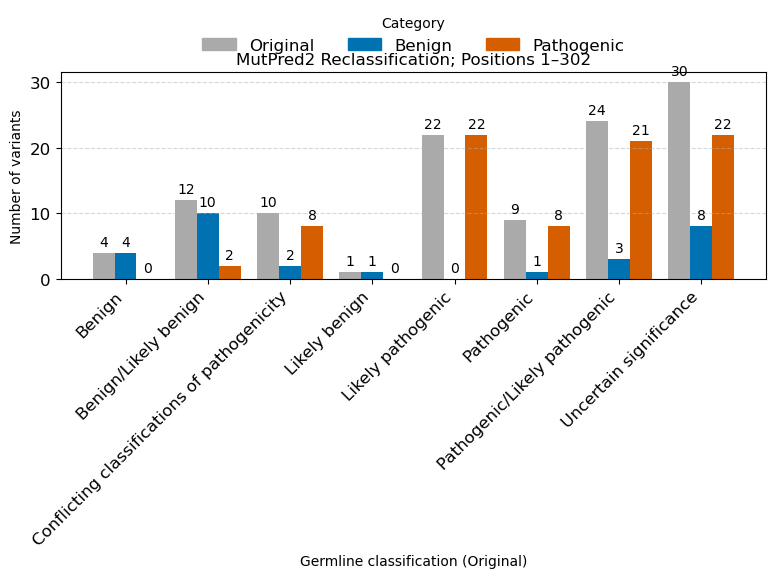


MutPred2 reclassified counts (Benign vs. Pathogenic) within positions 1–302:
mp2_binary
Benign        29
Pathogenic    83
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_mutpred2_reclassification(
    df: pd.DataFrame,
    position_range: tuple[int, int] = (1, 302),
    figsize: tuple[float, float] = (10, 6),
    title_fontsize: int = 16,
    label_fontsize: int = 14,
    tick_fontsize: int = 12,
    annotation_fontsize: int = 10,
    bar_width_ratio: float = 0.8,
    colors: dict | None = None,
    title: str | None = None
) -> pd.Series:
    """
    Plot original Germline classification counts alongside MutPred2 reclassification,
    and return the two‐class counts (Benign vs. Pathogenic).

    Parameters:
    - df: DataFrame with 'position', 'Germline classification', 'MutPred2_classification'
    - position_range: tuple(min, max) to filter 'position' (default 1–302)
    - figsize: (width, height) for the figure
    - title_fontsize: fontsize for title
    - label_fontsize: fontsize for axis labels
    - tick_fontsize: fontsize for tick labels
    - annotation_fontsize: fontsize for bar annotations
    - bar_width_ratio: total group width fraction
    - colors: dict mapping 'Original', 'Benign', 'Pathogenic' to colors
    - title: optional plot title

    Returns:
    - pd.Series: counts of 'Benign' and 'Pathogenic' after reclassification
    """
    # 1) Restrict to the specified position range (1–302 by default)
    start, end = position_range
    df = df[df['position'].between(start, end)].copy()

    # 2) Clean up the MutPred2_classification strings
    df['mp2_clean'] = df['MutPred2_classification'].str.lower().str.strip()

    # 3) Map to two classes: Benign stays Benign, everything else → Pathogenic
    df['mp2_binary'] = df['mp2_clean'].apply(
        lambda x: 'Benign' if x == 'benign' else 'Pathogenic'
    )

    # 4) Count the new binary classes
    binary_counts = df['mp2_binary'].value_counts().reindex(
        ['Benign', 'Pathogenic'],
        fill_value=0
    )

    # 5) Prepare the cross‐tab for the original vs. new classification plot
    cross = pd.crosstab(df['Germline classification'], df['mp2_binary'])
    original = df['Germline classification'].value_counts().reindex(cross.index)

    # Default colors
    if colors is None:
        colors = {
            'Original':   '#AAAAAA',
            'Benign':     '#0072B2',
            'Pathogenic': '#D55E00'
        }

    # Plot setup
    fig, ax = plt.subplots(figsize=figsize)
    plt.rcParams.update({'font.size': tick_fontsize})

    categories = ['Original', 'Benign', 'Pathogenic']
    n_groups = len(cross)
    total_width = bar_width_ratio
    bar_width = total_width / len(categories)
    x = np.arange(n_groups)

    # Plot bars + annotations
    for i, cat in enumerate(categories):
        counts = original.values if cat == 'Original' else cross.get(cat, pd.Series(0, index=cross.index)).values
        offset = -total_width/2 + i * bar_width + bar_width/2
        positions = x + offset
        ax.bar(positions, counts, bar_width, color=colors[cat], label=cat)
        for pos, cnt in zip(positions, counts):
            ax.text(pos, cnt + max(original.max(), cross.values.max())*0.02,
                    str(int(cnt)), ha='center', va='bottom',
                    fontsize=annotation_fontsize)

    # Labels and title
    ax.set_xticks(x)
    ax.set_xticklabels(cross.index, rotation=45, ha='right', fontsize=tick_fontsize)
    ax.set_xlabel('Germline classification (Original)', fontsize=label_fontsize)
    ax.set_ylabel('Number of variants', fontsize=label_fontsize)
    ax.set_title(
        title or f'MutPred2 Reclassification vs. Original (Positions {start}–{end})',
        fontsize=title_fontsize
    )

    # Legend above
    handles = [Patch(color=colors[c], label=c) for c in categories]
    ax.legend(handles=handles, title='Category',
              loc='lower center', bbox_to_anchor=(0.5, 1.02),
              ncol=len(handles), frameon=False,
              fontsize=tick_fontsize, title_fontsize=label_fontsize)

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return binary_counts


if __name__ == "__main__":
    # Path to  merged MutPred2 output
    file_path = (
        "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/02_mutpred2/"
        "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"
    )

    # Plot and get two‐class counts within positions 1–302
    df = pd.read_excel(file_path, engine="openpyxl")
    counts = plot_mutpred2_reclassification(df, position_range=(1, 302),
                                            figsize=(8, 6),
                                            title_fontsize=12,
                                            label_fontsize=10,
                                            tick_fontsize=12,
                                            annotation_fontsize=10,
                                            bar_width_ratio=0.8,
                                            title="MutPred2 Reclassification; Positions 1–302")

    # Print the reclassified counts
    print("\nMutPred2 reclassified counts (Benign vs. Pathogenic) within positions 1–302:")
    print(counts)


# 03 ESM

## 3.1 Run ESM under haddock3_env which has py3.11

In [ ]:
#!/usr/bin/env python
import os
import requests
import torch
import esm
import pandas as pd
import torch.nn.functional as F

# 1) Paths
DATA_XLSX     = "/project/ealexov/compbio/shamrat/250519_energy/00_data/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
OUTPUT_XLSX   = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/cdkl5_esm1v_clinvar_scores.xlsx"

# 2) Load      ClinVar/1KGP dataset
df = pd.read_excel(DATA_XLSX, engine="openpyxl")

# Keep only rows with non-null mutation info
df = df.loc[df['wild'].notna() & df['position'].notna() & df['mutant'].notna(), 
            ['wild','position','mutant']].drop_duplicates()

# Build a standard mutation string: e.g. I3F
df['mutation'] = df['wild'].str.upper() + df['position'].astype(int).astype(str) + df['mutant'].str.upper()
df = df.sort_values('position')

# 3) Fetch wild-type CDKL5 sequence from UniProt
resp = requests.get("https://rest.uniprot.org/uniprot/O76039.fasta")
resp.raise_for_status()
wt_seq = "".join(resp.text.splitlines()[1:]).strip()

# 4) Load the zero-shot variant model (ESM-1v)
device = torch.device('cpu')
model, alphabet = esm.pretrained.esm1v_t33_650M_UR90S_1()
model = model.eval().to(device)
batch_converter = alphabet.get_batch_converter()

def score_sequence(seq: str) -> float:
    """Return sum of per-residue log-probabilities under ESM-1v."""
    _, _, tokens = batch_converter([("cdkl5", seq)])
    tokens = tokens.to(device)
    with torch.no_grad():
        logits = model(tokens)["logits"][0, 1:len(seq)+1]
        logprobs = F.log_softmax(logits, dim=-1)
        aa_idxs = torch.tensor([alphabet.get_idx(a) for a in seq], device=device)
        return logprobs[torch.arange(len(seq)), aa_idxs].sum().item()

# 5) Compute wild-type score once
wt_score = score_sequence(wt_seq)

# 6) Loop over each variant
results = []
for _, row in df.iterrows():
    pos    = int(row['position'])
    wt_aa  = row['wild'].upper()
    mut_aa = row['mutant'].upper()
    mut_id = row['mutation']
    # sanity check
    assert wt_seq[pos-1] == wt_aa, f"WT mismatch at {pos}: found {wt_seq[pos-1]} vs expected {wt_aa}"
    # build the mutant sequence
    mut_seq = wt_seq[:pos-1] + mut_aa + wt_seq[pos:]
    mut_score = score_sequence(mut_seq)
    results.append({
        "mutation":    mut_id,
        "position":    pos,
        "wt_aa":       wt_aa,
        "mut_aa":      mut_aa,
        "wt_score":    wt_score,
        "mut_score":   mut_score,
        "delta_score": mut_score - wt_score
    })

# 7) Save to Excel
out_df = pd.DataFrame(results).sort_values('position')
out_df.to_excel(OUTPUT_XLSX, index=False)

print(f"✅ Written results to {OUTPUT_XLSX}")


## 3.2 Merge ESM-1v Δscore into CDKL5 variants and save

In [ ]:
# 3 use esm code for esm prediction this need py11 version and 'haddock3_env' has python11 version
# the code is loaded in '03_esm/score_cdkl5_variants.py'



# === 3.2 Merge ESM-1v Δscore into  CDKL5 variants and save ===

import pandas as pd
import os

# 1) Paths to      original variants and the ESM results
variants_xlsx = "/project/ealexov/compbio/shamrat/250519_energy/00_data/" \
                "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
esm_folder    = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm"
esm_results   = os.path.join(esm_folder, "cdkl5_esm1v_scores.xlsx")

# 2) Read in both tables
variants_df = pd.read_excel(variants_xlsx, engine="openpyxl")
esm_df      = pd.read_excel(esm_results,    engine="openpyxl")

# 3) Merge on the mutation string ('mutation' in variants ↔ 'mutation' in esm_df)
merged = variants_df.merge(
    esm_df,
    on="mutation",
    how="left"
)

# 4) Write out a new Excel with “_esm1v” appended
base = os.path.splitext(os.path.basename(variants_xlsx))[0]
out_path = os.path.join(
    esm_folder,
    f"{base}_esm1v.xlsx"
)
merged.to_excel(out_path, index=False)
print(f"Wrote merged ESM-1v annotations to {out_path}")



Wrote merged ESM-1v annotations to /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx


## 3.3 See the important columns

In [54]:
import pandas as pd

# Path to the merged ESM-1v annotations you just wrote
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)

# Load into a DataFrame
df = pd.read_excel(file_path, engine="openpyxl")

# Print only the column names
print("Columns in merged ESM-1v results:")
print(df.columns.tolist())


Columns in merged ESM-1v results:
['Name', 'Gene(s)', 'Protein change', 'mutation', 'wild', 'position_x', 'mutant', 'Allele Frequency', 'Condition(s)', 'Accession', 'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome', 'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence', 'Germline classification', 'Source', 'Germline date last evaluated', 'Germline review status', 'wild_score', 'mut_score', 'delta_score', 'position_y']


In [ ]:
import pandas as pd
from IPython.display import display

# Adjust this to actual file name:
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)

df = pd.read_excel(file_path, engine="openpyxl")

cols_to_display = [
    "mutation",
    "position_x",  # original position from variants
    "Germline classification",
    "wild_score",
    "mut_score",
    "delta_score"
]

print("Displayed columns:")
print(cols_to_display, "\n")

display(df[cols_to_display].head())


Displayed columns:
['mutation', 'position_x', 'Germline classification', 'wild_score', 'mut_score', 'delta_score'] 



,mutation,position_x,Germline classification,wild_score,mut_score,delta_score
0,I3F,3,Benign,-273.480652,-274.565460,-1.084808
1,N5D,5,Benign,-273.480652,-278.556641,-5.075989
2,F13S,13,Likely pathogenic,-273.480652,-283.678680,-10.198029
3,G20R,20,Pathogenic,-273.480652,-282.508423,-9.027771
4,G20V,20,Pathogenic,-273.480652,-288.576172,-15.095520


## 3.4 overview of the esm1v scores

In [ ]:
import pandas as pd
from IPython.display import display

# Path to  merged ESM-1v annotations file
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)

# Load it
df = pd.read_excel(file_path, engine="openpyxl")

# 1) Preview the first five rows of the key score columns
print("Head of ESM-1v scores:")
display(df[["mutation", "position_x", "wild_score", "mut_score", "delta_score"]].head())

# 2) Show summary statistics for those scores
print("\nSummary statistics for ESM-1v scores:")
display(df[["wild_score", "mut_score", "delta_score"]].describe())


Head of ESM-1v scores:


,mutation,position_x,wild_score,mut_score,delta_score
0,I3F,3,-273.480652,-274.565460,-1.084808
1,N5D,5,-273.480652,-278.556641,-5.075989
2,F13S,13,-273.480652,-283.678680,-10.198029
3,G20R,20,-273.480652,-282.508423,-9.027771
4,G20V,20,-273.480652,-288.576172,-15.095520



Summary statistics for ESM-1v scores:


,wild_score,mut_score,delta_score
count,156.000000,156.000000,156.000000
mean,-273.480652,-280.411024,-6.930372
std,0.000000,5.414785,5.414785
min,-273.480652,-291.536926,-18.056274
25%,-273.480652,-284.651039,-11.170387
50%,-273.480652,-281.149628,-7.668976
75%,-273.480652,-274.530075,-1.049423
max,-273.480652,-270.864868,2.615784


## 3.5 esm1v classification

In [ ]:
import pandas as pd
import os

# --- Configuration: update infile name if needed ---
esm_folder = "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm"
# Input filename (must match merged ESM-1v output)
infile = "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
# Output filename with 'classified' inserted before 'esm1v'
outfile = "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_esm1v.xlsx"

in_path = os.path.join(esm_folder, infile)
out_path = os.path.join(esm_folder, outfile)

# 1) Load merged ESM-1v results
df = pd.read_excel(in_path, engine="openpyxl")

# 2) Classify based on delta_score: negative → Pathogenic, else Benign
df['ESM1v_classification'] = df['delta_score'].apply(
    lambda x: 'Pathogenic' if x < 0 else 'Benign'
)

# 3) Save updated DataFrame
df.to_excel(out_path, index=False)
print(f"Wrote classified ESM-1v results to:\n  {out_path}")

# 4) Preview the first five rows with classification
from IPython.display import display
preview_cols = ['mutation', 'position_x', 'delta_score', 'ESM1v_classification']
print("Preview of classified ESM-1v results:")
display(df[preview_cols].head())


Wrote classified ESM-1v results to:
  /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_esm1v.xlsx
Preview of classified ESM-1v results:


,mutation,position_x,delta_score,ESM1v_classification
0,I3F,3,-1.084808,Pathogenic
1,N5D,5,-5.075989,Pathogenic
2,F13S,13,-10.198029,Pathogenic
3,G20R,20,-9.027771,Pathogenic
4,G20V,20,-15.095520,Pathogenic


## 3.6 esm1v reclassification plot

In [62]:
import pandas as pd
from IPython.display import display

# 1) Load the classified ESM-1v results
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_esm1v.xlsx"
)
df = pd.read_excel(file_path, engine="openpyxl")

# 2) Restrict to positions 1–302
df = df[df['position_x'].between(1, 302)]

# 3) Cross-tab: counts with totals
cross_counts = pd.crosstab(
    df['Germline classification'],
    df['ESM1v_classification'],
    margins=True,
    margins_name='Total'
)

# 4) Cross-tab: row-wise percentages (excluding Total column)
cross_pct = cross_counts.div(cross_counts['Total'], axis=0).round(2).drop(columns='Total')

# 5) Display
print("Counts:\n")
display(cross_counts)

print("\nPercentages:\n")
display(cross_pct)


Counts:



ESM1v_classification,Benign,Pathogenic,Total
Germline classification,,,
Benign,0,4,4
Benign/Likely benign,2,10,12
Conflicting classifications of pathogenicity,0,10,10
Likely benign,0,1,1
Likely pathogenic,0,22,22
Pathogenic,0,9,9
Pathogenic/Likely pathogenic,0,24,24
Uncertain significance,0,30,30
Total,2,110,112



Percentages:



ESM1v_classification,Benign,Pathogenic
Germline classification,,
Benign,0.00,1.00
Benign/Likely benign,0.17,0.83
Conflicting classifications of pathogenicity,0.00,1.00
Likely benign,0.00,1.00
Likely pathogenic,0.00,1.00
Pathogenic,0.00,1.00
Pathogenic/Likely pathogenic,0.00,1.00
Uncertain significance,0.00,1.00
Total,0.02,0.98


## 3.7 Find out ROC for ESM-1v

Total variants: 29  (Benign=20, Pathogenic=9)

AUC: 1.000
Optimal threshold details:
  Inverted Δscore cutoff: 6.152
  Sensitivity (TPR):      1.000
  Specificity:            1.000
  False positive rate:    0.000
  True positive rate:     1.000

Confusion matrix at optimal threshold:
  True Negatives: 20
  False Positives:0
  False Negatives:0
  True Positives: 9



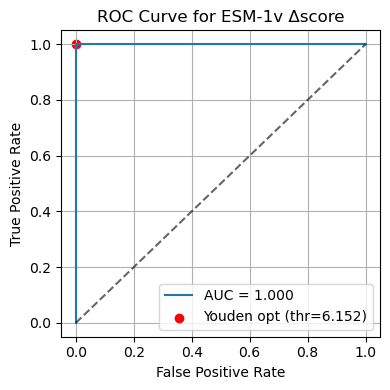

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

# ─── 1. Load and filter data ─────────────────────────────────────────────────
IN_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)
df = pd.read_excel(IN_XLSX, engine="openpyxl")
df = df[df['Germline classification'].isin(['Benign', 'Pathogenic'])].copy()

# ─── 2. Map true labels and compute scores ───────────────────────────────────
df['true_label'] = df['Germline classification'].map({'Benign': 0, 'Pathogenic': 1})
scores = -df['delta_score'].values  # invert so higher = more pathogenic
labels = df['true_label'].values

# ─── 3. Basic data summary ───────────────────────────────────────────────────
n_benign = (labels == 0).sum()
n_path   = (labels == 1).sum()
print(f"Total variants: {len(df)}  (Benign={n_benign}, Pathogenic={n_path})\n")

# ─── 4. ROC curve and AUC ────────────────────────────────────────────────────
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.3f}")

# ─── 5. Youden's J optimal threshold ─────────────────────────────────────────
youden_j        = tpr - fpr
opt_idx         = np.argmax(youden_j)
opt_threshold   = thresholds[opt_idx]
opt_sensitivity = tpr[opt_idx]
opt_specificity = 1 - fpr[opt_idx]
opt_fpr         = fpr[opt_idx]
opt_tpr         = tpr[opt_idx]

print("Optimal threshold details:")
print(f"  Inverted Δscore cutoff: {opt_threshold:.3f}")
print(f"  Sensitivity (TPR):      {opt_sensitivity:.3f}")
print(f"  Specificity:            {opt_specificity:.3f}")
print(f"  False positive rate:    {opt_fpr:.3f}")
print(f"  True positive rate:     {opt_tpr:.3f}\n")

# ─── 6. Confusion matrix at optimal threshold ────────────────────────────────
preds = (scores >= opt_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
print("Confusion matrix at optimal threshold:")
print(f"  True Negatives: {tn}")
print(f"  False Positives:{fp}")
print(f"  False Negatives:{fn}")
print(f"  True Positives: {tp}\n")

# ─── 7. Plot ROC Curve and mark optimal point ───────────────────────────────
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--', alpha=0.6)
plt.scatter(opt_fpr, opt_tpr, color='red',
            label=f"Youden opt (thr={opt_threshold:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for ESM-1v Δscore")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## 3.8 Apply empirically-derived threshold (Δscore < -6.152 → Pathogenic)

In [ ]:
import pandas as pd

# ─── 0. Paths ────────────────────────────────────────────────────────────────
IN_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)
OUT_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_custom_esm1v.xlsx"
)

# ─── 1. Load merged ESM-1v Δscore table ────────────────────────────────────
df = pd.read_excel(IN_XLSX, engine="openpyxl")

# ─── 2. Apply empirically-derived threshold (Δscore < -6.152 → Pathogenic)
threshold = -6.152
df['ESM1v_classification_custom'] = df['delta_score'].apply(
    lambda x: 'Pathogenic' if x < threshold else 'Benign'
)

# ─── 3. Summary counts ───────────────────────────────────────────────────────
counts = df['ESM1v_classification_custom'].value_counts().rename_axis('Class').reset_index(name='Count')
print("Custom ESM-1v classification counts:")
print(counts.to_string(index=False))

# ─── 4. Save out annotated Excel ─────────────────────────────────────────────
df.to_excel(OUT_XLSX, index=False)
print(f"\nWrote custom-classified ESM-1v table to:\n  {OUT_XLSX}")


Custom ESM-1v classification counts:
     Class  Count
Pathogenic     88
    Benign     68

Wrote custom-classified ESM-1v table to:
  /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/03_esm/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_custom_esm1v.xlsx


## 3.9 Plot full length and kinase domain

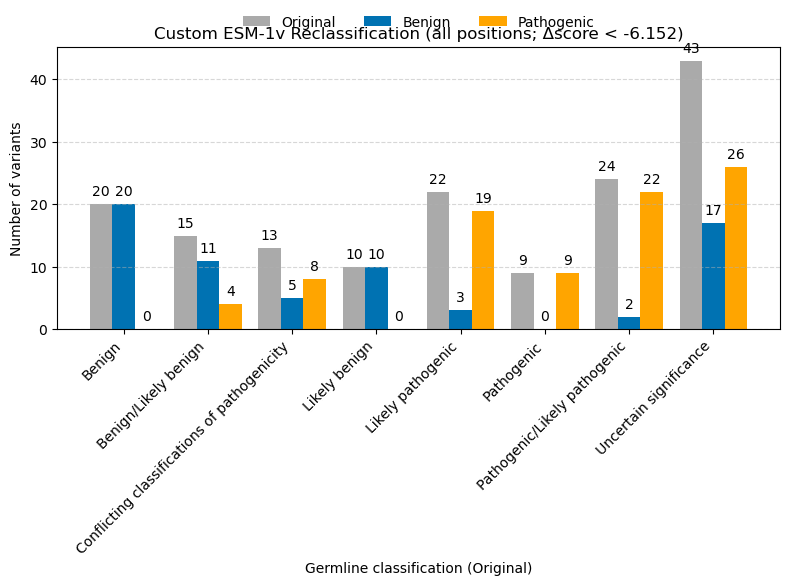

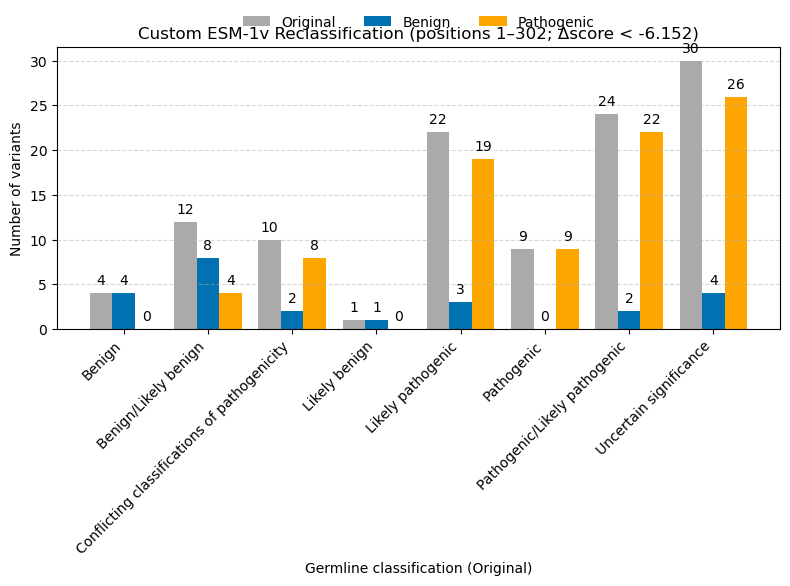

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─── 0. Path to      merged ESM-1v Δscore Excel ─────────────────────────────
IN_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)

# ─── 1. Load data and apply custom threshold ────────────────────────────────
df = pd.read_excel(IN_XLSX, engine="openpyxl")
threshold = -6.152
df['ESM1v_classification_custom'] = df['delta_score'].apply(
    lambda x: 'Pathogenic' if x < threshold else 'Benign'
)

# ─── Helper for position column ─────────────────────────────────────────────
pos_col = 'position_x' if 'position_x' in df.columns else 'position'

# ─── Prepare cross-tabs ─────────────────────────────────────────────────────
# All positions
cross_all = pd.crosstab(df['Germline classification'], df['ESM1v_classification_custom'])
orig_all  = df['Germline classification'].value_counts().reindex(cross_all.index)

# Positions 1–302
df_302    = df[df[pos_col].between(1, 302)]
cross_302 = pd.crosstab(df_302['Germline classification'], df_302['ESM1v_classification_custom'])
orig_302  = df_302['Germline classification'].value_counts().reindex(cross_302.index)

# ─── Color settings ─────────────────────────────────────────────────────────
colors = {
    'Original':   '#AAAAAA',
    'Benign':     '#0072B2',
    'Pathogenic': 'orange'
}

def plot_reclassification(cross, original, title):
    categories = ['Original', 'Benign', 'Pathogenic']
    total_w    = 0.8
    bar_w      = total_w / len(categories)
    x          = np.arange(len(cross))
    ymax       = max(original.max(), cross.values.max())

    fig, ax = plt.subplots(figsize=(8, 6))
    for i, cat in enumerate(categories):
        counts = original.values if cat == 'Original' else cross.get(cat, pd.Series(0, index=cross.index)).values
        offset = -total_w/2 + i * bar_w + bar_w/2
        pos    = x + offset
        ax.bar(pos, counts, bar_w, color=colors[cat], label=cat)
        for p, c in zip(pos, counts):
            ax.text(p, c + ymax*0.02, str(int(c)), ha='center', va='bottom')

    ax.set_xticks(x)
    ax.set_xticklabels(cross.index, rotation=45, ha='right')
    ax.set_xlabel('Germline classification (Original)')
    ax.set_ylabel('Number of variants')
    ax.set_title(title)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02),
              ncol=len(categories), frameon=False)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ─── Plot 1: all positions ───────────────────────────────────────────────────
plot_reclassification(
    cross_all, orig_all,
    f'Custom ESM-1v Reclassification (all positions; Δscore < {threshold})'
)

# ─── Plot 2: positions 1–302 ─────────────────────────────────────────────────
plot_reclassification(
    cross_302, orig_302,
    f'Custom ESM-1v Reclassification (positions 1–302; Δscore < {threshold})'
)


## 3.10 statistics

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve

# ─── 0. Load      merged ESM-1v results ─────────────────────────────────────────
IN_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)
df = pd.read_excel(IN_XLSX, engine="openpyxl")

# ─── 1. Filter to Benign/Pathogenic and map to binary labels ───────────────────
df = df[df['Germline classification'].isin(['Benign', 'Pathogenic'])].copy()
labels = df['Germline classification'].map({'Benign': 0, 'Pathogenic': 1}).values

# ─── 2. Extract Δscores and invert for ROC ─────────────────────────────────────
delta_scores = df['delta_score'].values
roc_scores = -delta_scores

# ─── 3. Compute ROC curve ──────────────────────────────────────────────────────
fpr, tpr, thresholds = roc_curve(labels, roc_scores)

# ─── 4. Print arrays so you can paste them back ────────────────────────────────
print("delta_scores =", np.round(delta_scores, 3).tolist())
print("roc_scores   =", np.round(roc_scores, 3).tolist())
print("thresholds   =", np.round(thresholds, 3).tolist())
print("fpr          =", np.round(fpr, 3).tolist())
print("tpr          =", np.round(tpr, 3).tolist())


delta_scores = [-1.085, -5.076, -9.028, -15.096, -6.673, -6.152, -8.001, -11.292, -10.646, -13.567, -14.875, -1.01, -3.107, 0.216, -0.209, -3.286, -0.363, -0.945, 0.904, -0.182, -2.743, -0.28, 0.613, 0.064, 0.624, -0.881, -5.23, -2.318, -0.418]
roc_scores   = [1.085, 5.076, 9.028, 15.096, 6.673, 6.152, 8.001, 11.292, 10.646, 13.567, 14.875, 1.01, 3.107, -0.216, 0.209, 3.286, 0.363, 0.945, -0.904, 0.182, 2.743, 0.28, -0.613, -0.064, -0.624, 0.881, 5.23, 2.318, 0.418]
thresholds   = [inf, 15.096, 6.152, -0.904]
fpr          = [0.0, 0.0, 0.0, 1.0]
tpr          = [0.0, 0.111, 1.0, 1.0]


In [ ]:
We start with the 29 CDKL5 variants, each having an ESM-1v delta_score:
[-1.085, -5.076, -9.028, -15.096, -6.673, -6.152, -8.001, -11.292,
 -10.646, -13.567, -14.875, -1.01, -3.107, 0.216, -0.209, -3.286,
 -0.363, -0.945, 0.904, -0.182, -2.743, -0.28, 0.613, 0.064, 0.624,
 -0.881, -5.23, -2.318, -0.418]

1. We invert these to obtain roc_scores = –delta_score:
[1.085, 5.076, 9.028, 15.096, 6.673, 6.152, 8.001, 11.292,
 10.646, 13.567, 14.875, 1.01, 3.107, -0.216, 0.209, 3.286,
 0.363, 0.945, -0.904, 0.182, 2.743, 0.28, -0.613, -0.064, -0.624,
 0.881, 5.23, 2.318, 0.418]

2. We run an ROC analysis (labels = 0 for Benign, 1 for Pathogenic) and get:
   thresholds = [∞,   15.096, 6.152, -0.904]
   fpr        = [0.0,   0.0,   0.0,   1.0]
   tpr        = [0.0, 0.111,   1.0,   1.0]

3. We compute Youden’s J = tpr – fpr for each threshold and find it is maximized at:
   threshold = 6.152  (i.e. delta_score = –6.152)
   → TPR = 1.00 (we catch all 9 known pathogenic)
   → FPR = 0.00 (we flag no benign)

4. Therefore our classification rule becomes:
   if delta_score < -6.152:
       classification = "Pathogenic"
   else:
       classification = "Benign"

5. We can now apply this same rule to any new CDKL5 variant: compute its delta_score, compare to –6.152,
and assign a “Benign” or “Pathogenic” label.


## 3.11 classification

In [ ]:
#!/usr/bin/env python3
import pandas as pd

# ─── 0. Path to merged ESM-1v Δscore Excel ─────────────────────────────
IN_XLSX = (
    "/project/ealexov/compbio/shamrat/250519_energy/"
    "05_pathogenicity/03_esm/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"
)

# ─── 1. Load data and apply custom threshold ────────────────────────────────
df = pd.read_excel(IN_XLSX, engine="openpyxl")
threshold = -6.152
df['ESM1v_classification_custom'] = df['delta_score'].apply(
    lambda x: 'Pathogenic' if x < threshold else 'Benign'
)

# ─── 2. Identify the correct position column ────────────────────────────────
pos_col = 'position_x' if 'position_x' in df.columns else 'position'

# ─── 3. Subset to positions 1–302 ────────────────────────────────────────────
df_302 = df[df[pos_col].between(1, 302)]

# ─── 4. Compute counts for the two classes within 1–302 ─────────────────────
counts_302 = (
    df_302['ESM1v_classification_custom']
    .value_counts()
    .reindex(['Benign', 'Pathogenic'], fill_value=0)
)

# ─── 5. Print the results ───────────────────────────────────────────────────
print(f"Custom ESM-1v counts (Δscore < {threshold}) within positions 1–302:")
print(counts_302)


Custom ESM-1v counts (Δscore < -6.152) within positions 1–302:
ESM1v_classification_custom
Benign        24
Pathogenic    88
Name: count, dtype: int64


# 04 Alphamissense

In [6]:
import pandas as pd

# Corrected file path variable name
alphamissense = '/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/08_alphamissense/AF-O76039-F1-hg38.csv'

# Use read_csv instead of read_excel since it's a .csv file
df = pd.read_csv(alphamissense)

# Display the first 5 rows
print(df.head())


  CHROM       POS REF ALT genome uniprot_id      transcript_id  \
0  chrX  18507100   A   C   hg38     O76039  ENST00000623535.2   
1  chrX  18507100   A   G   hg38     O76039  ENST00000623535.2   
2  chrX  18507101   A   G   hg38     O76039  ENST00000623535.2   
3  chrX  18507101   A   T   hg38     O76039  ENST00000623535.2   
4  chrX  18507101   A   C   hg38     O76039  ENST00000623535.2   

  protein_variant  am_pathogenicity           am_class  
0             K2Q            0.3231      likely_benign  
1             K2E            0.5673  likely_pathogenic  
2             K2R            0.1027      likely_benign  
3             K2M            0.7349  likely_pathogenic  
4             K2T            0.5335          ambiguous  


In [7]:
## 08 alphamissense
#!/usr/bin/env python3
import pandas as pd
import os

# ─── Paths ───────────────────────────────────────────────────────────────────
variants_xlsx     = "/project/ealexov/compbio/shamrat/250519_energy/00_data/" \
                    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"
alphamissense_csv = "/project/ealexov/compbio/shamrat/250519_energy/" \
                    "05_pathogenicity/08_alphamissense/AF-O76039-F1-hg38.csv"
out_dir           = "/project/ealexov/compbio/shamrat/250519_energy/" \
                    "05_pathogenicity/08_alphamissense"

# ─── 1. Load data ─────────────────────────────────────────────────────────────
variants_df = pd.read_excel(variants_xlsx, engine="openpyxl")
am_df       = pd.read_csv(alphamissense_csv)

# ─── 2. Normalize merge keys ─────────────────────────────────────────────────
variants_df['mutation']        = variants_df['mutation'].astype(str)
am_df['protein_variant']       = am_df['protein_variant'].astype(str)

# ─── 3. Prepare AlphaMissense lookup ─────────────────────────────────────────
am_small = (
    am_df[['protein_variant', 'am_pathogenicity', 'am_class']]
    .rename(columns={'protein_variant': 'mutation'})
).drop_duplicates('mutation', keep='first')

# ─── 4. Map back onto variants_df ────────────────────────────────────────────
lookup = am_small.set_index('mutation')
variants_df['am_pathogenicity'] = variants_df['mutation'].map(lookup['am_pathogenicity'])
variants_df['am_class']         = variants_df['mutation'].map(lookup['am_class'])

# ─── 5. Quick confirmation ────────────────────────────────────────────────────
total   = len(variants_df)
matched = variants_df['am_pathogenicity'].notna().sum()
print(f"Pulled AlphaMissense results for {matched}/{total} variants.")

# Show a few example rows to confirm correct columns
print(variants_df[['mutation','am_pathogenicity','am_class']].head().to_string(index=False))

# ─── 6. Write out merged Excel ────────────────────────────────────────────────
base     = os.path.splitext(os.path.basename(variants_xlsx))[0]
out_path = os.path.join(out_dir, f"{base}_alphamissense.xlsx")
variants_df.to_excel(out_path, index=False)
print(f"Wrote {total} rows to {out_path}")


Pulled AlphaMissense results for 156/156 variants.
mutation  am_pathogenicity          am_class
     I3F            0.1217     likely_benign
     N5D            0.0945     likely_benign
    F13S            0.9996 likely_pathogenic
    G20R            1.0000 likely_pathogenic
    G20V            0.9995 likely_pathogenic
Wrote 156 rows to /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/08_alphamissense/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx


## investigation on alphamissense data

In [63]:
import pandas as pd
from IPython.display import display

# Update this to the actual merged AlphaMissense Excel filename
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/08_alphamissense/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"
)

# Load the merged AlphaMissense results
df_am = pd.read_excel(file_path, engine="openpyxl")

# 1) Print all column names
print("Columns in merged AlphaMissense results:")
print(df_am.columns.tolist(), "\n")

# 2) Preview key columns
cols_to_display = [
    "mutation",
    "position",
    "Germline classification",
    "am_pathogenicity",
    "am_class"
]
print("Preview of AlphaMissense annotations:")
display(df_am[cols_to_display].head())

# 3) Summary stats for the pathogenicity scores
print("\nSummary statistics for AlphaMissense pathogenicity scores:")
display(df_am["am_pathogenicity"].describe())


Columns in merged AlphaMissense results:
['Name', 'Gene(s)', 'Protein change', 'mutation', 'wild', 'position', 'mutant', 'Allele Frequency', 'Condition(s)', 'Accession', 'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome', 'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence', 'Germline classification', 'Source', 'Germline date last evaluated', 'Germline review status', 'am_pathogenicity', 'am_class'] 

Preview of AlphaMissense annotations:


,mutation,position,Germline classification,am_pathogenicity,am_class
0,I3F,3,Benign,0.1217,likely_benign
1,N5D,5,Benign,0.0945,likely_benign
2,F13S,13,Likely pathogenic,0.9996,likely_pathogenic
3,G20R,20,Pathogenic,1.0000,likely_pathogenic
4,G20V,20,Pathogenic,0.9995,likely_pathogenic



Summary statistics for AlphaMissense pathogenicity scores:


count    156.000000
mean       0.700047
std        0.397183
min        0.046600
25%        0.181000
50%        0.993300
75%        0.999700
max        1.000000
Name: am_pathogenicity, dtype: float64

In [ ]:
import pandas as pd
from IPython.display import display

# 1) Load  merged AlphaMissense results
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/08_alphamissense/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"
)
df_am = pd.read_excel(file_path, engine="openpyxl")

# 2) Filter to positions 1–302 if you like
df_am = df_am[df_am['position'].between(1, 302)]

# 3) Cross-tabulate counts
counts = pd.crosstab(
    df_am['Germline classification'],
    df_am['am_class'],
    margins=True,
    margins_name='Total'
)
print("AlphaMissense reclassification counts:")
display(counts)

# 4) Cross-tabulate percentages (per original Germline row)
pct = counts.div(counts['Total'], axis=0).round(2).drop(columns='Total')
print("\nAlphaMissense reclassification percentages:")
display(pct)


AlphaMissense reclassification counts:


am_class,ambiguous,likely_benign,likely_pathogenic,Total
Germline classification,,,,
Benign,0,3,1,4
Benign/Likely benign,0,7,5,12
Conflicting classifications of pathogenicity,0,0,10,10
Likely benign,0,0,1,1
Likely pathogenic,0,0,22,22
Pathogenic,0,0,9,9
Pathogenic/Likely pathogenic,1,0,23,24
Uncertain significance,1,2,27,30
Total,2,12,98,112



AlphaMissense reclassification percentages:


am_class,ambiguous,likely_benign,likely_pathogenic
Germline classification,,,
Benign,0.00,0.75,0.25
Benign/Likely benign,0.00,0.58,0.42
Conflicting classifications of pathogenicity,0.00,0.00,1.00
Likely benign,0.00,0.00,1.00
Likely pathogenic,0.00,0.00,1.00
Pathogenic,0.00,0.00,1.00
Pathogenic/Likely pathogenic,0.04,0.00,0.96
Uncertain significance,0.03,0.07,0.90
Total,0.02,0.11,0.88


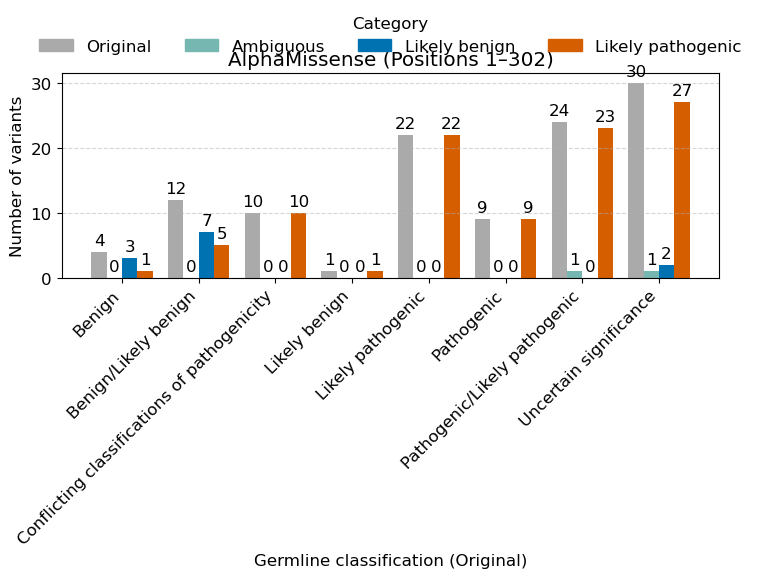

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load merged AlphaMissense annotations
file_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/08_alphamissense/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"
)
df = pd.read_excel(file_path, engine="openpyxl")

# Filter to positions 1–302
df = df[df['position'].between(1, 302)]

# Cross-tabulate original vs. AlphaMissense classes
order = ['ambiguous', 'likely_benign', 'likely_pathogenic']
cross = pd.crosstab(df['Germline classification'], df['am_class'])[order]

# Original counts
original = df['Germline classification'].value_counts().reindex(cross.index)

# Plot settings
colors = {
    'Original':        '#AAAAAA',
    'ambiguous':       '#76B7B2',  # muted green
    'likely_benign':   '#0072B2',  # blue
    'likely_pathogenic':'#D55E00' # orange
}

fig, ax = plt.subplots(figsize=(8, 6))
n_groups = len(cross)
n_bars = 1 + len(order)
total_width = 0.8
bar_width = total_width / n_bars
x = np.arange(n_groups)

# Plot grey original
for i, key in enumerate(['Original'] + order):
    if key == 'Original':
        counts = original.values
    else:
        counts = cross[key].values
    offset = -total_width/2 + i * bar_width + bar_width/2
    positions = x + offset
    ax.bar(positions, counts, bar_width, color=colors[key], label=key if key=='Original' else key.replace('_',' ').capitalize())
    for pos, cnt in zip(positions, counts):
        ax.text(pos, cnt + max(original.max(), cross.values.max())*0.02, str(int(cnt)), ha='center', va='bottom')

# Labels & title
ax.set_xticks(x)
ax.set_xticklabels(cross.index, rotation=45, ha='right')
ax.set_xlabel('Germline classification (Original)')
ax.set_ylabel('Number of variants')
ax.set_title('AlphaMissense (Positions 1–302)')

# Legend above plot
handles = [
    Patch(color=colors['Original'], label='Original')
] + [
    Patch(color=colors[k], label=k.replace('_',' ').capitalize()) for k in order
]
ax.legend(handles=handles, title='Category', loc='lower center',
          bbox_to_anchor=(0.5, 1.02), ncol=len(handles), frameon=False)

ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd

def resolve_ambiguous_alphamissense(
    file_path: str,
    position_range: tuple[int,int] = (1,302),
    threshold: float = 0.5
) -> pd.Series:
    """
    Load AlphaMissense annotations, restrict to the given position range,
    then reclassify any 'ambiguous' entries based on the numeric am_pathogenicity score.

    - If am_pathogenicity >= threshold  → Pathogenic
    - Else                               → Benign

    Finally returns counts of the two classes.
    """
    # 1) Load & subset
    df = pd.read_excel(file_path, engine="openpyxl")
    start, end = position_range
    df = df[df['position'].between(start, end)].copy()

    # 2) New binary column
    def reclass(row):
        if row['am_class'] != 'ambiguous':
            # keep original likely_benign/pathogenic
            return 'Benign' if row['am_class']=='likely_benign' else 'Pathogenic'
        # ambiguous → decide by score
        return 'Pathogenic' if row['am_pathogenicity'] >= threshold else 'Benign'

    df['final_class'] = df.apply(reclass, axis=1)

    # 3) Tally
    counts = df['final_class'].value_counts().reindex(
        ['Benign','Pathogenic'], fill_value=0
    )
    return counts

if __name__ == "__main__":
    file_path = (
        "/project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/"
        "08_alphamissense/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx"
    )

    # Try with threshold = median (≈0.9933) or T=0.5
    for T in [0.5, 0.9933]:
        counts = resolve_ambiguous_alphamissense(file_path, (1,302), threshold=T)
        print(f"\nThreshold = {T:.4f}:")
        print(counts)



Threshold = 0.5000:
final_class
Benign        14
Pathogenic    98
Name: count, dtype: int64

Threshold = 0.9933:
final_class
Benign        14
Pathogenic    98
Name: count, dtype: int64


# 05 Analysis

## 5.1 Variant reclassificaiton based on pathogenicity prediction

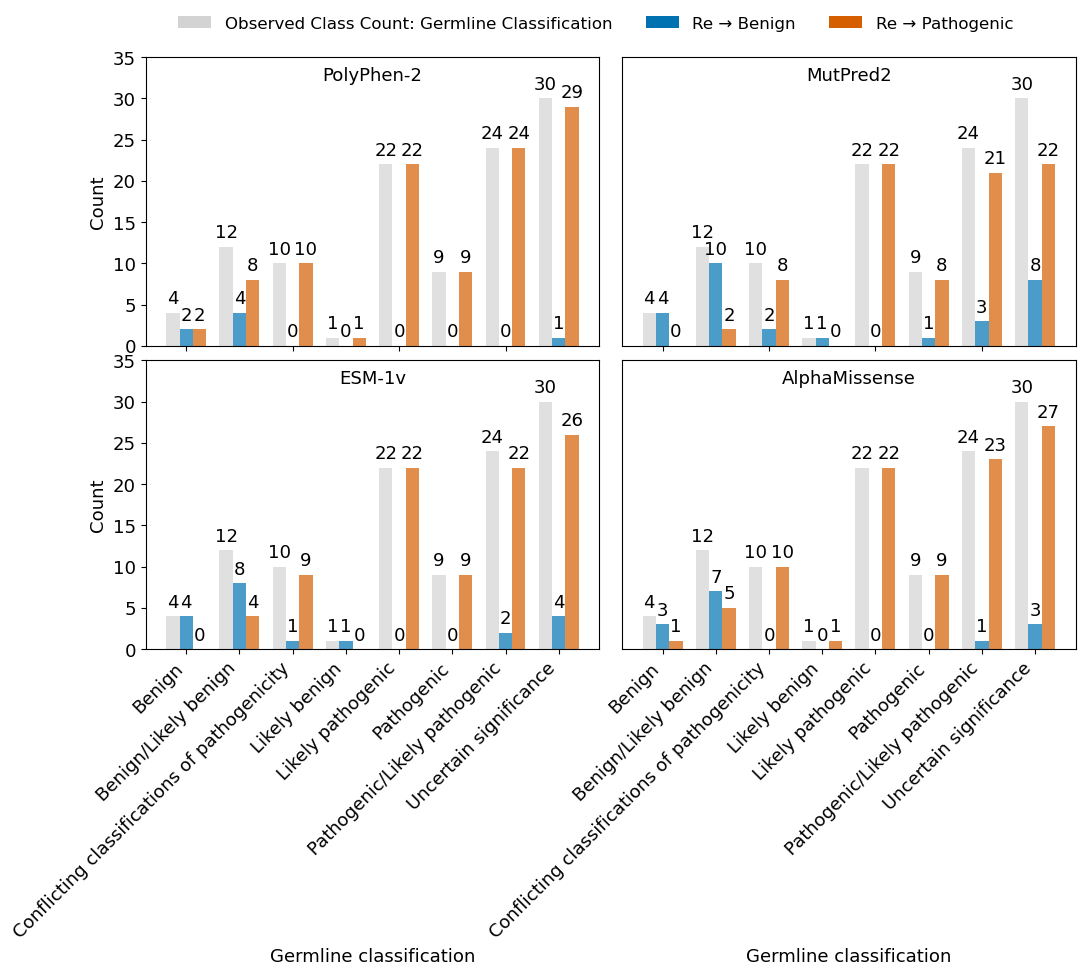

Saved plot to: /project/ealexov/compbio/shamrat/250519_energy/05_pathogenicity/all_methods_reclassification.png


In [129]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib.patches import Patch

# ── Paths ─────────────────────────────────────────────────────────────────
root      = "/project/ealexov/compbio/shamrat/250519_energy"
save_path = os.path.join(root, "05_pathogenicity", "all_methods_reclassification.png")

files = {
    'Original':      os.path.join(root, "00_data",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"),
    'PolyPhen-2':    os.path.join(root, "05_pathogenicity/01_polyphen2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"),
    'MutPred2':      os.path.join(root, "05_pathogenicity/02_mutpred2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"),
    'ESM-1v':        os.path.join(root, "05_pathogenicity/03_esm",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"),
    'AlphaMissense': os.path.join(root, "05_pathogenicity/08_alphamissense",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx")
}

def load1_302(path):
    df = pd.read_excel(path, engine='openpyxl')
    pos = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[pos].between(1,302)].copy()

# ── Load & prepare ─────────────────────────────────────────────────────────
dfs       = {name: load1_302(fp) for name, fp in files.items()}
orig_ser  = dfs['Original']['Germline classification']
orig_order = sorted(orig_ser.unique())

# PolyPhen-2
pp2 = dfs['PolyPhen-2'].copy()
pp2['Recall'] = pp2['prediction']\
                  .str.lower().str.strip()\
                  .map(lambda x: 'Benign' if x=='benign' else 'Pathogenic')

# MutPred2
mp2 = dfs['MutPred2'].copy()
mp2['Recall'] = mp2['MutPred2_classification']

# ESM-1v
es = dfs['ESM-1v'].copy()
es['true'] = (es['Germline classification']!='Benign').astype(int)
fpr, tpr, thr = roc_curve(es['true'], -es['delta_score'])
cutoff_es = -thr[np.argmax(tpr - fpr)]
es['Recall'] = es['delta_score'].apply(lambda x: 'Benign' if x>=cutoff_es else 'Pathogenic')

# AlphaMissense
am = dfs['AlphaMissense'].copy()
full_am = pd.read_excel(files['AlphaMissense'], engine='openpyxl')
amb     = full_am[full_am['am_class']=='ambiguous']['am_pathogenicity']
pat     = full_am[full_am['am_class']=='likely_pathogenic']['am_pathogenicity']
cutoff_am = (amb.max() + pat.min()) / 2
am['Recall'] = am['am_class']\
                  .map(lambda c: 'Benign' if c in ['likely_benign','ambiguous'] else 'Pathogenic')
mask = am['am_class']=='ambiguous'
am.loc[mask, 'Recall'] = am.loc[mask,'am_pathogenicity']\
                             .apply(lambda s: 'Benign' if s<cutoff_am else 'Pathogenic')

# ── Plot helper ───────────────────────────────────────────────────────────
def plot_grouped(ax, orig_ser, rec_ser, title):
    x = np.arange(len(orig_order))
    w = 0.25
    orig_cnt = orig_ser.value_counts().reindex(orig_order).values
    ct = pd.crosstab(orig_ser, rec_ser)\
           .reindex(index=orig_order, columns=['Benign','Pathogenic'], fill_value=0)
    rb, rp = ct['Benign'].values, ct['Pathogenic'].values

    ax.bar(x-w, orig_cnt, w, color='lightgray', alpha=0.7)
    ax.bar(x,   rb,       w, color='#0072B2', alpha=0.7)
    ax.bar(x+w, rp,       w, color='#D55E00', alpha=0.7)

    ymax = max(orig_cnt.max(), rb.max(), rp.max())
    for c in ax.containers:
        for r in c:
            h = r.get_height()
            ax.text(r.get_x()+r.get_width()/2,
                    h + ymax*0.02, str(int(h)),
                    ha='center', va='bottom', fontsize=10)

    ax.set_title(title, y=0.92, pad=0, loc='center')

# ── Build figure ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2,
                         figsize=(14, 10),
                         sharey='row',
                         gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

axes = axes.flatten()
sequence = [
    ('PolyPhen-2',    pp2['Recall']),
    ('MutPred2',      mp2['Recall']),
    ('ESM-1v',        es['Recall']),
    ('AlphaMissense', am['Recall'])
]

for idx, (ax, (name, rec)) in enumerate(zip(axes, sequence)):
    plot_grouped(ax, orig_ser, rec, name)

    if idx < 2:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(len(orig_order)))
        ax.set_xticklabels(orig_order, rotation=45, ha='right')

    if idx % 2 == 1:
        ax.get_yaxis().set_visible(False)

for ax in axes:
    ax.set_ylim(0, 35)
    ax.set_yticks(np.arange(0, 36, 5))

# ── Single legend (with descriptive labels) ──────────────────────────────
handles = [
    Patch(facecolor='lightgray', label='Observed Class Count: Germline Classification'),
    Patch(facecolor='#0072B2',    label='Re → Benign'),
    Patch(facecolor='#D55E00',    label='Re → Pathogenic')
]
fig.subplots_adjust(top=0.88)
fig.legend(handles=handles,
           loc='upper center',
           bbox_to_anchor=(0.5, 0.92),
           ncol=3,
           frameon=False,
           fontsize=12)

for ax in axes[2:]:
    ax.set_xlabel('Germline classification', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[2].set_ylabel('Count', fontsize=14)

# ── Cosmetic Helper Functions ─────────────────────────────────────────────
def set_figure_size(fig, width, height):
    fig.set_size_inches(width, height)

def set_global_font(size):
    plt.rcParams.update({'font.size': size})

def set_axis_label_font(ax, xlabel_size=None, ylabel_size=None):
    if xlabel_size is not None:
        ax.xaxis.label.set_size(xlabel_size)
    if ylabel_size is not None:
        ax.yaxis.label.set_size(ylabel_size)

def set_tick_font(ax, tick_size):
    ax.tick_params(axis='both', labelsize=tick_size)

def set_title_font(ax, size):
    ax.title.set_fontsize(size)

def set_bar_text_font(ax, size):
    for txt in ax.texts:
        txt.set_fontsize(size)

def adjust_spacing(fig, wspace=None, hspace=None, top=None):
    fig.subplots_adjust(
        wspace = wspace if wspace is not None else fig.subplotpars.wspace,
        hspace = hspace if hspace is not None else fig.subplotpars.hspace,
        top    = top    if top    is not None else fig.subplotpars.top
    )

# ── Cosmetics Block: call here to tweak everything ────────────────────────
FIG_WIDTH        = 12
FIG_HEIGHT       = 8
GLOBAL_FONT      = 13
TITLE_FONT       = 13
TICK_FONT        = 13
LABEL_FONT       = 13
BAR_TEXT_FONT    = 13
WSPACE           = 0.10
HSPACE           = 0.10
TOP_MARGIN       = 0.85

# apply
set_figure_size(fig, FIG_WIDTH, FIG_HEIGHT)
set_global_font(GLOBAL_FONT)
for ax in axes:
    set_title_font(ax, TITLE_FONT)
    set_axis_label_font(ax, xlabel_size=LABEL_FONT, ylabel_size=LABEL_FONT)
    set_tick_font(ax, TICK_FONT)
    set_bar_text_font(ax, BAR_TEXT_FONT)

adjust_spacing(fig, wspace=WSPACE, hspace=HSPACE, top=TOP_MARGIN)
# ── End Cosmetics ─────────────────────────────────────────────────────────

# ── Save & display ────────────────────────────────────────────────────────
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print("Saved plot to:", save_path)


## 5.2 Variant reclassificaiton counts based on pathogenicity

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve

# ── Paths ───────────────────────────────────────────────────────────────────
root = "/project/ealexov/compbio/shamrat/250519_energy"
files = {
    'Original':      os.path.join(root, "00_data",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg.xlsx"),
    'PolyPhen-2':    os.path.join(root, "05_pathogenicity/01_polyphen2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_polyphen2.xlsx"),
    'MutPred2':      os.path.join(root, "05_pathogenicity/02_mutpred2",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_classified_mutpred2.xlsx"),
    'ESM-1v':        os.path.join(root, "05_pathogenicity/03_esm",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_esm1v.xlsx"),
    'AlphaMissense': os.path.join(root, "05_pathogenicity/08_alphamissense",
                                  "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af_noddg_alphamissense.xlsx")
}

def load1_302(path):
    df = pd.read_excel(path, engine='openpyxl')
    pos = 'position_x' if 'position_x' in df.columns else 'position'
    return df[df[pos].between(1,302)].copy()

# ── Load & filter ───────────────────────────────────────────────────────────
dfs = {name: load1_302(fp) for name, fp in files.items()}
orig = dfs['Original']['Germline classification'].reset_index(drop=True)

# ── Label “Recall” for each method ───────────────────────────────────────────
# PolyPhen-2
pp2 = dfs['PolyPhen-2'].copy()
pp2['Recall'] = pp2['prediction'].str.lower().map(lambda x: 'Benign' if x=='benign' else 'Pathogenic')

# MutPred2
mp2 = dfs['MutPred2'].copy()
mp2['Recall'] = mp2['MutPred2_classification']

# ESM-1v: ROC cutoff
es = dfs['ESM-1v'].copy()
es['true'] = (es['Germline classification']!='Benign').astype(int)
fpr, tpr, thr = roc_curve(es['true'], -es['delta_score'])
cut_es = -thr[np.argmax(tpr-fpr)]
es['Recall'] = es['delta_score'].apply(lambda x: 'Benign' if x>=cut_es else 'Pathogenic')

# AlphaMissense
am = dfs['AlphaMissense'].copy()
full_am = pd.read_excel(files['AlphaMissense'], engine='openpyxl')
amb = full_am[full_am['am_class']=='ambiguous']['am_pathogenicity']
pat = full_am[full_am['am_class']=='likely_pathogenic']['am_pathogenicity']
cut_am = (amb.max() + pat.min())/2
def recall_am(r):
    if r['am_class']=='likely_benign':
        return 'Benign'
    if r['am_class']=='ambiguous':
        return 'Benign' if r['am_pathogenicity']<cut_am else 'Pathogenic'
    return 'Pathogenic'
am['Recall'] = am.apply(recall_am, axis=1)

# ── Helper to print counts ───────────────────────────────────────────────────
def summarize(name, recall_ser):
    print(f"\n{name}:")
    print(" Original counts:")
    print(orig.value_counts().to_string())
    print(" Recalled counts:")
    print(recall_ser.value_counts().to_string())
    print(" Crosstab Original vs Recall:")
    print(pd.crosstab(orig, recall_ser).to_string())
    
# ── Print summaries for each method ─────────────────────────────────────────
summarize("PolyPhen-2",    pp2['Recall'])
summarize("MutPred2",      mp2['Recall'])
summarize("ESM-1v",        es['Recall'])
summarize("AlphaMissense", am['Recall'])



PolyPhen-2:
 Original counts:
Germline classification
Uncertain significance                          30
Pathogenic/Likely pathogenic                    24
Likely pathogenic                               22
Benign/Likely benign                            12
Conflicting classifications of pathogenicity    10
Pathogenic                                       9
Benign                                           4
Likely benign                                    1
 Recalled counts:
Recall
Pathogenic    112
 Crosstab Original vs Recall:
Recall                                        Pathogenic
Germline classification                                 
Benign                                                 4
Benign/Likely benign                                  12
Conflicting classifications of pathogenicity          10
Likely benign                                          1
Likely pathogenic                                     22
Pathogenic                                             9
Pathogen